<center><h1> Empirical Assignment 4</h1></center>

**Author(s):**
1. Belicia Rodriguez (belicia.rodriguez@emory.edu)

**Objectives**: This <ins>assignment</ins> aims at
 1. Learning how to adapt other people's code to one needs;
 2. Use *GitHub* to retrieve and submit computer code.

**Instructions**:
 1. Please write down your Python code and <ins>execute</ins> it in the cell below each question.
 
 **Data Source**: [Introductory Econometrics: A Modern Approach](https://cran.r-project.org/web/packages/wooldridge/index.html) by Jeffrey Wooldridge

**Data Description**: ```http://fmwww.bc.edu/ec-p/data/wooldridge/hprice1.dta```

```
Contains data from hprice1.dta
  obs:            88                          
 vars:            10                          17 Mar 2002 12:21
 size:         3,168 (99.5% of memory free)
-------------------------------------------------------------------------------
              storage  display     value
variable name   type   format      label      variable label
-------------------------------------------------------------------------------
price           float  %9.0g                  house price, $1000s
assess          float  %9.0g                  assessed value, $1000s
bdrms           byte   %9.0g                  number of bdrms
lotsize         float  %9.0g                  size of lot in square feet
sqrft           int    %9.0g                  size of house in square feet
colonial        byte   %9.0g                  =1 if home is colonial style
lprice          float  %9.0g                  log(price)
lassess         float  %9.0g                  log(assess
llotsize        float  %9.0g                  log(lotsize)
lsqrft          float  %9.0g                  log(sqrft)
-------------------------------------------------------------------------------
Sorted by:  
 ```
 
 **Background**: Consider the general model
 
 $$
\begin{aligned}
\texttt{lprice} &= \beta_{0} + \beta_{1}\texttt{llotsize} +  \beta_{2}\texttt{lsqrft} +\beta_{3}\texttt{colonial}+\beta_{4}\texttt{bdrms}\\
&+ \beta_{5}\texttt{colonial}\times\texttt{llotsize}+ \beta_{6}\texttt{colonial}\times\texttt{lsqrft}++ \beta_{7}\texttt{colonial}\times\texttt{bdrms}+ e.
\end{aligned}
$$

You now know that a relatively unknown _alternative_ measure of fit, $\widetilde{R}^2$, is defined as

$$
\widetilde{R}^{2}=1-\frac{\sum_{i=1}^{n} \widetilde{e}_{i}^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}},
$$

where $\{\widetilde{e}_i;i=1,\dots,n\}$ are the _prediction errors_ previously discussed in class, and $\{y_i;i=1,\dots,n\}$ represents the elements $\{\texttt{lprice} _i;i=1,\dots,n\}$ in the ```hprice1``` data set. Recall that $\widetilde{R}^2$ estimates the percentage of the forecast variance which is explained by the regression forecast. You think this is a better measure of _fitness_ than the $RSS$ or the classical $R^2$.
 
<center><h2> Questions</h2></center>

1. [15 points] Proceed to modify the previously defined ```processSubset``` Python function so it returns this new quantity $\widetilde{R}^2$ instead of the $RSS$ (called ```ssr``` by the ```statsmodels``` library).

In [2]:
import pandas as pd
import numpy as np
import patsy
import itertools
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# redefine processSubset to calculate new R^2
def processSubset(feature_set):
    # fit model on feature_set
    model = OLS(y,X[list(feature_set)])
    reg = model.fit()
    
    # calculate new R^2
    predict_errors = ((reg.resid/(1 - reg.get_influence().hat_matrix_diag))**2).sum()
    sum_of_squares = (reg.centered_tss)
    R2 = 1 - (predict_errors/sum_of_squares)
    
    return {'model':reg, 'new R2':R2}

2. [35 points] Using the entire set of 88 observations proceed to find out all the best 7 specifications using the **Best Subset Selection** algorithm discussed in class that utilizes the proposed $\widetilde{R}^2$ measure of fit instead. *Note*: All these 7 specifications must contain an intercept per our discussion in class.

In [3]:
# import hprice1 dataset
hprice1 = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/hprice1.dta')

# create design matrix of specification
f = 'lprice ~ llotsize + lsqrft + colonial + bdrms + colonial:llotsize + colonial:lsqrft + colonial:bdrms'
y,X = patsy.dmatrices(f, data=hprice1, return_type='dataframe')

# demean outcome and features: subtract sample mean from each observation
y = y.sub(y.mean())
X = X.sub(X.mean()).drop('Intercept', axis=1)

# define getBest function
def getBest(p):
    # create empty array to store results
    results = []
    
    # 
    for combo in itertools.combinations(X.columns,p):
        results.append(processSubset(combo))

    # put results in dataframe
    models = pd.DataFrame(results)
    
    # choose model with lowest new R^2
    best_model = models.loc[models['new R2'].argmax()]
    return best_model

# collect the best models using a loop
models_best = pd.DataFrame(columns=['model','new R2'])

for i in range(1,8):
    models_best.loc[i] = getBest(i)
    
print(models_best)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


                                               model    new R2
1  <statsmodels.regression.linear_model.Regressio...  0.538504
2  <statsmodels.regression.linear_model.Regressio...  0.613883
3  <statsmodels.regression.linear_model.Regressio...  0.613524
4  <statsmodels.regression.linear_model.Regressio...  0.607329
5  <statsmodels.regression.linear_model.Regressio...  0.590002
6  <statsmodels.regression.linear_model.Regressio...  0.564622
7  <statsmodels.regression.linear_model.Regressio...  0.471542


**Comment:** pay attention to the warning and use idxmax instead of argmax

3. [50 points] For each of the best 7 specifications you found to maximize the forecast variance that is explained by the regression forecast in the previous question, proceed to calculate the cross-validated errors in a $10$-fold (using a seed equal to $42$). For example, let's assume that the best model that includes just one regressor using the entire sample of 88 observations and the $\widetilde{R}^2$ is the model that regresses ```lprice``` on ```colonial```. Using the partition of the first fold, proceed to use the 90% of the observations to fit this model and then predict the ```lprice``` in the remaining 10% in this fold, and modified *again* your ```processSubset``` function to return the RSS, see, e.g., the Python code in the lecture notes. Save this value and then do the same for the next fold, save this value, and continue doing it till you have 10 RSS values corresponding to the $10$-fold. Average these 10 values and save it. Then do the same with the best model you found that contains 2 regressors, then the best that contains 3 regressors, and so on till you do the same for the complete model with 7 features. Plot these average values and proceed to report the model with the *smallest* cross-validated error. Then fit (```.summary()```) this *best* model using the entire sample.

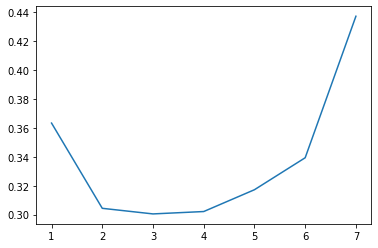

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 lprice   R-squared (uncentered):                   0.651
Model:                            OLS   Adj. R-squared (uncentered):              0.639
Method:                 Least Squares   F-statistic:                              52.94
Date:                Thu, 05 Mar 2020   Prob (F-statistic):                    2.13e-19
Time:                        11:50:23   Log-Likelihood:                          26.912
No. Observations:                  88   AIC:                                     -47.82
Df Residuals:                      85   BIC:                                     -40.39
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
llotsize           0.1663      0.038      4.422      0.000       0.092       0.241
lsqrft             0.7287      0.081      9.010      0.000       0.568       0.890
colonial:bdrms     0.0212      0.011      1.981      0.051   -8.12e-05       0.042
==============================================================================
Omnibus:                       14.054   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               53.903
Skew:                           0.032   Prob(JB):                     1.97e-12
Kurtosis:                       6.834   Cond. No.                         7.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# modify processSubset function to return RSS
def processFold(r, X_train, X_test, y_train, y_test):    
    # run OLS and fit a regression
    model = sm.OLS(y_train, X_train[list(r)])
    regr = model.fit()
    
    # predict test set and calculate RSS
    RSS = ((regr.predict(X_test[list(r)]) - y_test.iloc[:,0])**2).sum()

    return RSS

# run a kFold and get the RSS of each fold, then calculate the average of RSS
def runKfold_getavgRSS(i):
    # itialize empty array
    RSS = []

    # split data into 10 folds and collect RSS values
    for train_index, test_index in kf.split(hprice1_array):
        # divide dataframe into test and train
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
    
        # define which regressor(s) to analyze
        regressor = models_best['model'][i].model.exog_names
    
        # send to processFold to get RSS
        rss_value = processFold(regressor, X_train, X_test, y_train, y_test)
    
        # append RSS value to 
        RSS.append(rss_value)
    
    # take average of the RSS collected in the kFold
    RSS_avg_value = np.mean(RSS)
    
    return RSS_avg_value

# create kfold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# change hprice1 from dataframe to array for kfold 
hprice1_array = hprice1.to_numpy()

# initiate an empty list
RSS_avgs = pd.DataFrame(columns=['R2'], index=range(1,8), dtype='float64')

# run a loop to go through each best model and collect the RSS averages
for i in (range(1,8)):
    a = runKfold_getavgRSS(i)
    RSS_avgs.loc[i] = a
    
# create graph of RSS averages
plt.plot(RSS_avgs)
plt.show()

# choose model with lowest error
smallest = RSS_avgs['R2'].argmin()

# display summary of the model
models_best['model'][smallest].summary()

**Comment:** again, be careful with the warnings